In [1]:
%pip install mediapipe
%pip install tensorflow
%pip install scickit-learn
%pip install numpy
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement scickit-learn (from versions: none)
ERROR: No matching distribution found for scickit-learn


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
import os
import cv2 as cv
import numpy as np
import mediapipe as mp
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [3]:
def calculate_angle(a, b, c, landmarks):
  a -= 11
  b -= 11
  c -= 11
  a = np.array(landmarks[a])
  b = np.array(landmarks[b])
  c = np.array(landmarks[c])
  radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
  angle = np.abs(radians*180.0/np.pi)

  if angle > 180.0:
      angle = 360 - angle

  return angle


In [4]:
keypoints_to_consider = []
graph = {
    11: [12, 23],
    12: [11, 24],
    13: [],
    14: [],
    15: [],
    16: [],
    17: [],
    18: [],
    19: [],
    20: [],
    21: [],
    22: [],
    23: [11, 24, 25],
    24: [12, 23, 26],
    25: [23, 27],
    26: [24, 28],
    27: [25, 29, 31],
    28: [26, 30, 32],
    29: [27, 31],
    30: [28, 32],
    31: [27, 29],
    32: [28, 30]
}

In [5]:
def dfs(current):
    if len(current) == 3:
        if current[0] < current[2]:
            keypoints_to_consider.append(current.copy())
        return

    for node in graph[current[-1]]:
       dfs(current=current + [node])

In [6]:
for i in range(11, 33):
  dfs([i])
NUM_ANGLES = len(keypoints_to_consider)

In [7]:
def get_landmark_array(landmarks):
  lms = []
  result = []
  for l in landmarks:
    lms.append([l.x, l.y]) # 'z' will not be taken in consideration assuming that the image is a perfect or semi-perfect side view of a body, so z will not make a difference
  lms = np.array(lms[11:])
  for points in keypoints_to_consider:
    result.append(calculate_angle(*points, lms))
  return np.array(result)

In [8]:
def preprocess(data, labels, img, label):
    mp_pose = mp.solutions.pose
    imgRGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    imgflipped = cv.flip(imgRGB, 1)
    imgZoom2p = cv.resize(imgRGB, None, fx=1.1, fy=1.1, interpolation=cv.INTER_LINEAR)
    imgZoomxp = cv.resize(imgRGB, None, fx=1.1, fy=1, interpolation=cv.INTER_LINEAR)
    imgZoomyp = cv.resize(imgRGB, None, fx=1, fy=1.1, interpolation=cv.INTER_LINEAR)
    imgZoomxn = cv.resize(imgRGB, None, fx=0.9, fy=1, interpolation=cv.INTER_LINEAR)
    imgZoomyn = cv.resize(imgRGB, None, fx=1, fy=0.9, interpolation=cv.INTER_LINEAR)
    imgZoom2n = cv.resize(imgRGB, None, fx=0.9, fy=0.9, interpolation=cv.INTER_LINEAR)
    imgZoom2xp = cv.resize(imgRGB, None, fx=0.8, fy=0.8, interpolation=cv.INTER_LINEAR)
    imgZoom2xn = cv.resize(imgRGB, None, fx=1.2, fy=1.2, interpolation=cv.INTER_LINEAR)


    AugmentedImages = [imgRGB, imgflipped, imgZoom2p, imgZoomxp, imgZoomyp, imgZoomxn, imgZoomyn, imgZoom2n, imgZoom2xp, imgZoom2xn]    

    for image in AugmentedImages:
      with mp_pose.Pose(min_detection_confidence=0.2) as pose:
        result = pose.process(image)
        if not result.pose_landmarks: continue
        data.append(get_landmark_array(result.pose_landmarks.landmark))
        labels.append(label)

In [9]:
def load_data():
    data = []
    labels = []
    print('Loading False Images')
    for filename in os.listdir(os.path.join(os.getcwd(), 'Incorrect')):
        img = cv.imread(os.path.join(os.getcwd(), 'Incorrect', filename))
        print(filename)
        preprocess(data, labels, img, 0)
    print('Loading True Images')
    for filename in os.listdir(os.path.join(os.getcwd(), 'Correct')):
        print(filename)
        img = cv.imread(os.path.join(os.getcwd(), 'Correct', filename))
        try:
          preprocess(data, labels, img, 1)
        except:
          pass

    data = np.array(data) / 180.0
    labels = np.array(labels)

    return data, labels


In [10]:
def make_model():
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Input((NUM_ANGLES, 1)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation="relu"))
    model.add(tf.keras.layers.Dense(512, activation="relu"))
    model.add(tf.keras.layers.Dense(512, activation="relu"))
    model.add(tf.keras.layers.Dense(512, activation="relu"))
    model.add(tf.keras.layers.Dense(512, activation="relu"))
    model.add(tf.keras.layers.Dense(512, activation="relu"))
    model.add(tf.keras.layers.Dropout(0.25))

    # Output Layer
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [11]:
data, labels = load_data()
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

Loading False Images
204758387_0717masterWeb_t800.jpg
25998567cc58756f_bend.webp
A78A8712-2-scaled.webp
bG3bfatJnCt3GgP9heZMwA-320-80.jpg
ebwallsit-1595624372.png
istockphoto-924163488-612x612.jpg
right_0.jpg
right_11 - Copy.jpg
right_11.jpg
right_203.jpg
right_241.jpg
right_255.jpg
right_350.jpg
right_397.jpg
right_42 - Copy.jpg
right_42.jpg
right_425.jpg
right_428.jpg
right_43.jpg
right_44 - Copy.jpg
right_44.jpg
right_440.jpg
right_459.jpg
right_504.jpg
right_512.jpg
right_54.jpg
right_826.jpg
right_872.jpg
thigh-exercise-1557754707.jpg
Loading True Images
0_ozhgyAsa4LP7Ihi8.jpg
1.webp
6af3bd_ae3c40b732a040f4a2ca488dac3b024d~mv2.webp
94064b90-5c1a-4d10-a1d5-084f789bdef6-getty-1090188000.avif
download (1).jpg
download (2).jpg
download.jpg
fit-woman-doing-wall-sit-260nw-697078645.webp
gettyimages-886478720-612x612.jpg
How-to-Do-a-Perfect-Wall-Sit-1600x900-1.jpeg
imageds.jpg
images (1).jpg
images.jpg
master-the-wall-sit.webp
maxresdefault.jpg
TJAS4L5TRN4O3NSCJICRTNJKEA.avif
wall-sit-60

In [12]:
x_train[0]

array([0.47452418, 0.37354996, 0.52895193, 0.53457975, 0.61734612,
       0.54002162, 0.84263226, 0.49361277, 0.15540197, 0.49758793,
       0.7639523 , 0.53028735, 0.75585465, 0.60645201, 0.2170029 ,
       0.07723675, 0.24827881, 0.11402786, 0.70576035, 0.63769333])

In [13]:
x_train.shape

(384, 20)

In [14]:
model = make_model()

Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5306 - loss: 0.6644 - val_accuracy: 0.5729 - val_loss: 0.5614
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6763 - loss: 0.5194 - val_accuracy: 0.9167 - val_loss: 0.3032
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9063 - loss: 0.2705 - val_accuracy: 0.9271 - val_loss: 0.2142
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9313 - loss: 0.1871 - val_accuracy: 0.8854 - val_loss: 0.2570
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9461 - loss: 0.1723 - val_accuracy: 0.8854 - val_loss: 0.3208
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9544 - loss: 0.1134 - val_accuracy: 0.9271 - val_loss: 0.1968
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9490 - loss: 0.1271 - val_accuracy: 0.9375 - val_loss: 0.1796
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9812 - loss: 0.0574 - val_accuracy: 0.

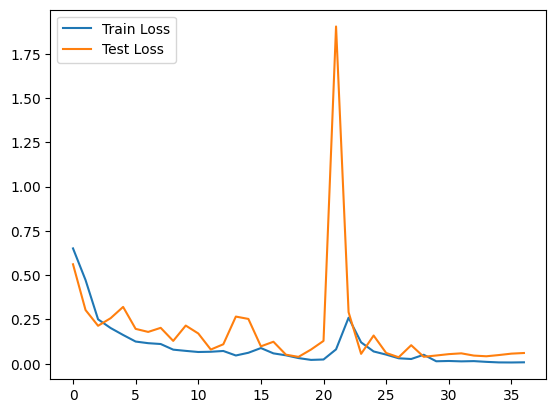

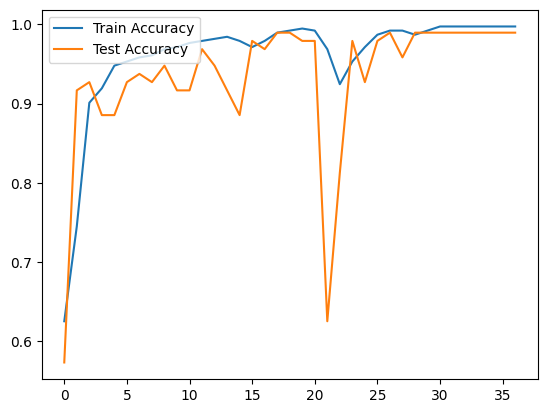

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=150, validation_data=(x_test, y_test), callbacks=[early_stopping])
loss, accuracy = model.evaluate(x_test, y_test, verbose=2)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend(loc="upper left")
plt.show()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend(loc="upper left")
plt.show()

In [16]:
model.save(f'{(accuracy * 100):.4f}.h5')

In [17]:
def confusion_matrix(model, test, labels):
    y_pred = model.predict(test)
    y_pred = np.round(y_pred)

    confusion_matrix = metrics.confusion_matrix(labels, y_pred)
    
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])   
    cm_display.plot()
    plt.show()


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


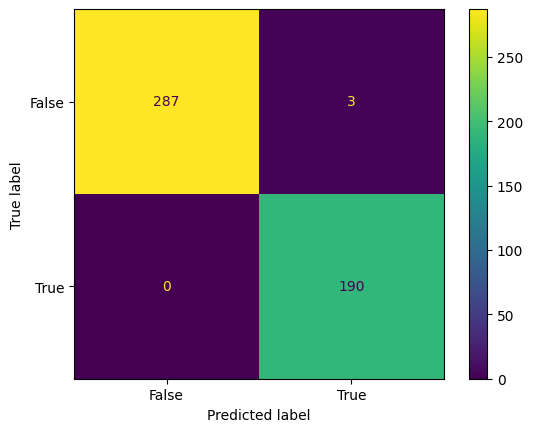

In [18]:
confusion_matrix(model, data, labels)

This image is detected as True but it's in fact False

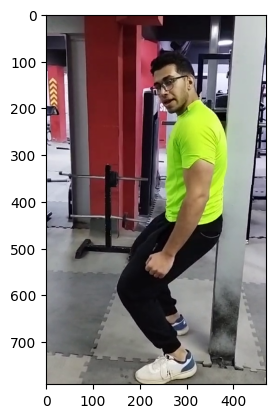

In [26]:
errorPhoto = cv.imread('john.png')
errorPhoto = cv.cvtColor(errorPhoto, cv.COLOR_BGR2RGB)
plt.imshow(errorPhoto)